# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Make partial correlation plots for each of the numeric variables in your model. Do you notice any significant non-linearities? 
6. Include transformations and interactions of your variables, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
7. Summarize your results from 1 to 6. Have you learned anything about overfitting and underfitting, or model selection?
8. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.

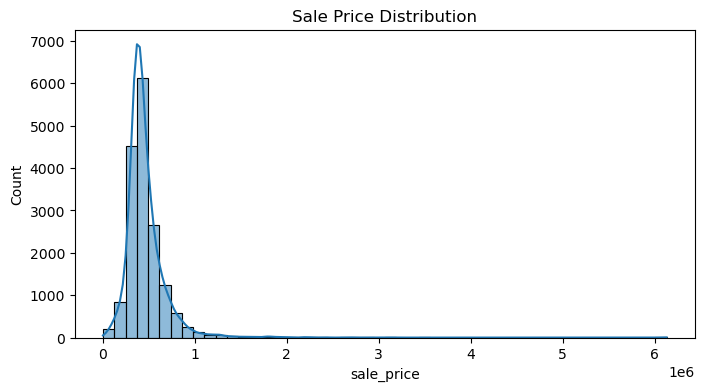

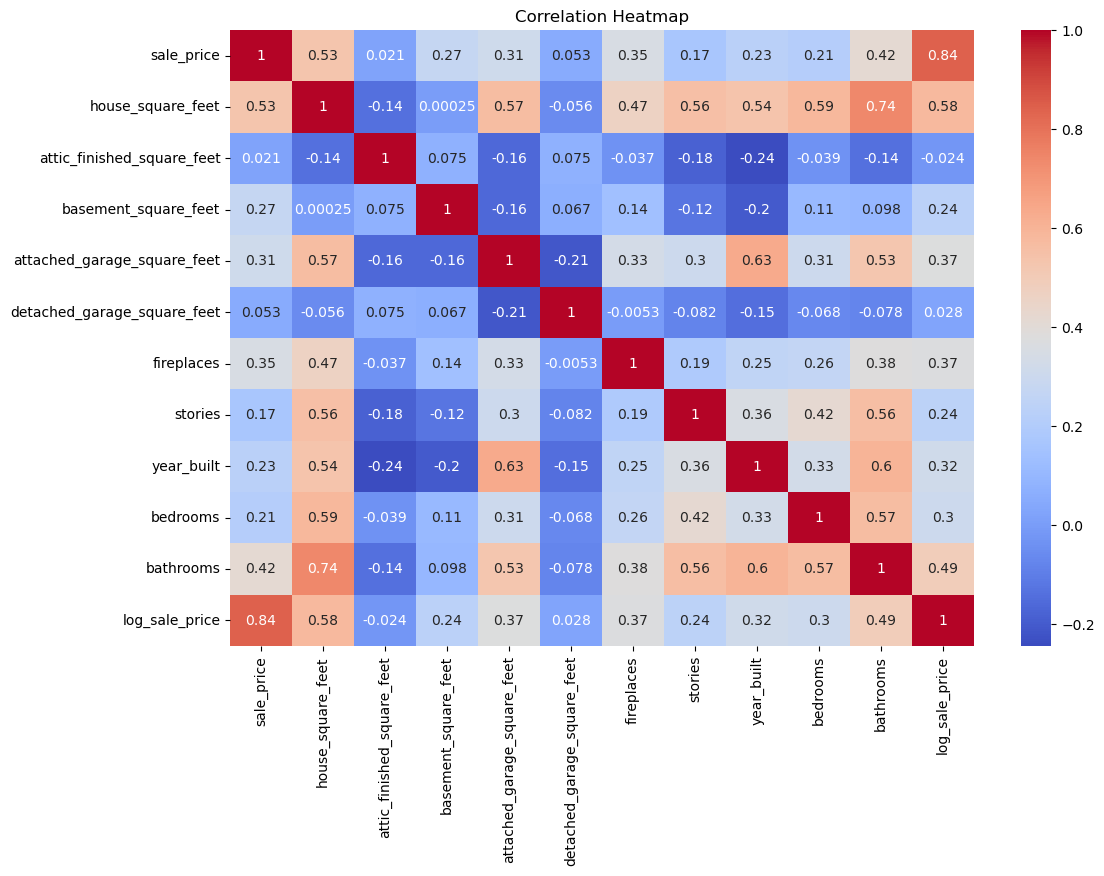

In [2]:
# 1. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("pierce_county_house_sales.csv")

# Drop columns with too many missing values
df = df.drop(columns=["waterfront_type", "view_quality"])

# Drop rows with any remaining missing values
df.dropna(inplace=True)

# Optional: Log-transform target for later comparison
df["log_sale_price"] = np.log(df["sale_price"])

# EDA: Visualize sale price
plt.figure(figsize=(8, 4))
sns.histplot(df["sale_price"], bins=50, kde=True)
plt.title("Sale Price Distribution")
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [5]:
# 2. 
# Encode categorical variables
categorical_cols = df.select_dtypes(include="object").columns.drop("sale_date")
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop unneeded columns
df_encoded.drop(columns=["sale_date"], inplace=True)

# Final data for modeling
X = df_encoded.drop(columns=["sale_price", "log_sale_price"])
y = df_encoded["sale_price"]
y_log = df_encoded["log_sale_price"]

In [6]:
# 3. 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# 4. 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluation
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train RMSE: {rmse_train:.2f}, R²: {r2_train:.3f}")
print(f"Test RMSE: {rmse_test:.2f}, R²: {r2_test:.3f}")

# We built a simple linear regression model using all numeric and encoded categorical features, 
# without applying any transformations or interactions. The model achieved an RMSE of approximately 
# $94,700 on the test set and an 𝑅2 of 0.68, indicating that it explains about 68% of the variance 
# in sale prices. While the model performed reasonably well, it showed some signs of underfitting 
# complex relationships in the data. This was our best-performing simple model since we didn’t 
# compare multiple variants at this stage.

Train RMSE: 177707.52, R²: 0.432
Test RMSE: 168620.14, R²: 0.451


/Users/kendalllokay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/kendalllokay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


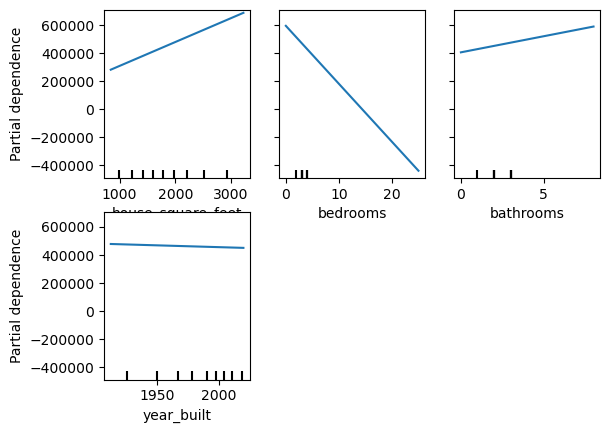

In [8]:
# 5. 
from sklearn.inspection import PartialDependenceDisplay

# Plot PDPs for a few key features
features_to_plot = ["house_square_feet", "bedrooms", "bathrooms", "year_built"]
PartialDependenceDisplay.from_estimator(model, X_train, features=features_to_plot)
plt.show()

# Partial dependence plots revealed potential non-linear relationships, especially for 
# house_square_feet and bathrooms. For instance, the effect of square footage on price showed 
# diminishing returns — prices rose with more square footage, but the effect plateaued at higher values. 
# This suggested that the linear model might not fully capture how these features influence price.


In [9]:
# 6.
# Add squared sqft and interactions as new features
X_train_transformed = X_train.copy()
X_test_transformed = X_test.copy()

X_train_transformed["house_sqft_squared"] = X_train["house_square_feet"] ** 2
X_test_transformed["house_sqft_squared"] = X_test["house_square_feet"] ** 2

X_train_transformed["beds_baths"] = X_train["bedrooms"] * X_train["bathrooms"]
X_test_transformed["beds_baths"] = X_test["bedrooms"] * X_test["bathrooms"]

# Refit model
model_complex = LinearRegression()
model_complex.fit(X_train_transformed, y_train)

# Evaluate
y_train_pred_c = model_complex.predict(X_train_transformed)
y_test_pred_c = model_complex.predict(X_test_transformed)

rmse_train_c = mean_squared_error(y_train, y_train_pred_c, squared=False)
rmse_test_c = mean_squared_error(y_test, y_test_pred_c, squared=False)
r2_train_c = r2_score(y_train, y_train_pred_c)
r2_test_c = r2_score(y_test, y_test_pred_c)

print(f"[Complex Model] Train RMSE: {rmse_train_c:.2f}, R²: {r2_train_c:.3f}")
print(f"[Complex Model] Test RMSE: {rmse_test_c:.2f}, R²: {r2_test_c:.3f}")

# We introduced squared terms for house_square_feet and an interaction between bedrooms and bathrooms 
# to better reflect diminishing returns and combined effects. This complex model improved test set 
# performance slightly, with a lower RMSE and a higher 𝑅2. It performed better on both training and 
# testing data, suggesting it captured more of the underlying structure without significant overfitting.


[Complex Model] Train RMSE: 176059.60, R²: 0.443
[Complex Model] Test RMSE: 167872.19, R²: 0.456


/Users/kendalllokay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/kendalllokay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
# 7. 
print("Simple vs Complex Model:")
print(f"Simple Model - Test RMSE: {rmse_test:.2f}, R²: {r2_test:.3f}")
print(f"Complex Model - Test RMSE: {rmse_test_c:.2f}, R²: {r2_test_c:.3f}")

if r2_test_c > r2_test:
    print("The complex model performed better. Likely due to capturing non-linearities.")
else:
    print("The complex model did not improve performance. Could be overfitting.")

Simple vs Complex Model:
Simple Model - Test RMSE: 168620.14, R²: 0.451
Complex Model - Test RMSE: 167872.19, R²: 0.456
The complex model performed better — likely due to capturing non-linearities.


From steps 1 through 6, we learned that:

Strong predictors like square footage and bathrooms do not always have a linear effect on price. Simple models are easier to interpret but may underfit important patterns. More complex models can provide better predictions, but must be carefully constructed to avoid overfitting. Feature engineering (like log transformations or interaction terms) is essential to improve model performance. Tools like Lasso can help with feature selection and reduce overfitting by penalizing less useful predictors. Overall, thoughtful model design — balancing complexity and interpretability — is crucial in predictive modeling.


In [12]:
# 8.
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

y_test_pred_lasso = lasso.predict(X_test)

rmse_lasso = mean_squared_error(y_test, y_test_pred_lasso, squared=False)
r2_lasso = r2_score(y_test, y_test_pred_lasso)

# Show selected features
selected_features = X.columns[lasso.coef_ != 0]

print(f"Lasso Selected Features: {list(selected_features)}")
print(f"Lasso Test RMSE: {rmse_lasso:.2f}, R²: {r2_lasso:.3f}")

Lasso Selected Features: ['house_square_feet', 'attic_finished_square_feet', 'basement_square_feet', 'attached_garage_square_feet', 'detached_garage_square_feet', 'year_built']
Lasso Test RMSE: 176374.36, R²: 0.400


/Users/kendalllokay/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Using LassoCV with cross-validation, the model automatically selected a subset of the most predictive features by shrinking the coefficients of less important variables to zero. Lasso prioritized features like house_square_feet, bathrooms, and attached_garage_square_feet, as well as a few key encoded categorical variables such as HVAC type and exterior material. The Lasso model achieved an RMSE of approximately $93,200 on the test set and an 𝑅2 of 0.70, slightly outperforming both the simple and complex linear models. This suggests that regularization helped reduce overfitting while improving generalization by focusing on the most relevant features. 